In [1]:
import gym
from gym import Env
from gym.spaces import Discrete
import time

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from IPython.display import clear_output
from enum import Enum
import cv2 as cv

# plt.ion()

In [82]:
class GameEnvV1(Env):
    def __init__(self, m, n, initial_pos):
        super(GameEnvV1, self).__init__()
        self.grid = np.zeros(tuple([m, n]))
        self.rows = m;
        self.cols = n;
        # should have just used Discrete type here.
        self.action_space = {  # agent position is a number between 1 and m * n 
            'Up': -self.cols,   # moving up makes us move across m cells (if they were laid out in a line)
            'Down': self.cols,
            'Left': -1,
            'Right': 1,
            'Stall': 0}
        #self.T = np.zeros(self.action_space) # action counts
        self.reward = {  # 4 rewards.
            (m - 1, n - 1): 10,
            (1, 1): -1,
            (0, 2): 1,
            (2, 1): 3
        }
        self.used_reward = []
        self.agent_position = initial_pos
        self.set_grid_values();

    def get_coordinate_from_position(self, pos):
        m = pos // self.cols
        n = pos % self.cols
        return (m, n)
    
    def set_grid_values(self):
        self.grid = np.zeros(tuple([self.rows, self.cols]))
        self.grid[self.get_coordinate_from_position(self.agent_position)] = 2
        for reward_loc in self.reward.keys():
            self.grid[reward_loc] = 5 * self.reward[reward_loc]

    def is_action_possible(self, action):  # might not be needed. Added for later convenience 
#         print(f'is possible? {action}')
        if action not in self.action_space.keys():
            return False;

        if self.agent_position % self.cols == 0 and action == 'Left':
            # can't move left as we are at the edge
            return False;
        
        if self.agent_position % self.cols == self.cols - 1 and action == 'Right':
            # can't move right as we are at the edge
            return False;
        
        if self.agent_position // self.cols == 0 and action == 'Up':
            # can't move up as we are at the 1st row
            return False;
        
        if self.agent_position // self.cols == self.rows - 1 and action == 'Down':
            # can't move down as we are at the last row
            return False;
        
        return True;

    def step(self, action):
        if not self.is_action_possible(action):
            return self.agent_position, -1, False, {};

        self.grid[self.get_coordinate_from_position(self.agent_position)] = 0
        self.agent_position += self.action_space[action];
        self.grid[self.get_coordinate_from_position(self.agent_position)] = 5

        reward = -1
        m, n = self.get_coordinate_from_position(self.agent_position)
        if (m, n) in self.reward and (m, n) not in self.used_reward:
            reward = self.reward[(m, n)]
            self.used_reward.append((m, n));
#             print(f'reward: {reward}, pos: {(m, n)}, used: {self.used_reward}')

        terminal = False;
        if self.agent_position == self.rows * self.cols - 1:
            terminal = True;

        return self.agent_position, reward, terminal, {}

    def update_est(self, action, reward):
        self.T[action] += 1
        alpha = 1./self.T[action]
        self.est_values[action] += alpha * (reward - self.est_values[action])  # keeps running average of rewards

    def reset(self):
        self.agent_position = 0
        self.set_grid_values()
        self.used_reward = []

    def render(self):
        clear_output(wait = True)
        plt.imshow(self.grid)
        plt.show()
        # using open cv below. But it is getting too time consuming for more than 3 many elements
#         img_rows, img_cols = (501, 501)
#         rows, cols = (4, 4)

#         x = np.linspace(start=0, stop=img_rows - 1, num=rows + 1)
#         y = np.linspace(start=0, stop=img_cols - 1, num=cols + 1)

#         for line_pos in x:
#             x1 = int(line_pos)
#             y1 = 0
#             y2 = img_rows - 1
#             cv.line(newMat_3ch, (x1,y1), (x1, y2), (0,0,255),1 )  # img, start, end, col, thickness

#         for line_pos in y:
#             x1 = 0
#             y1 = int(line_pos)
#             x2 = img_cols - 1
#             cv.line(newMat_3ch, (x1, y1), (x2, y1), (255,0,0), 1)

#         cv.namedWindow('GridWorld',0)
#         cv.imshow('GridWorld', newMat_3ch)
#         cv.waitKey(0)
#         cv.destroyAllWindows()
        

In [83]:
def draw_grid(img, grid_shape, color=(0, 255, 0), thickness=1):
    h, w, _ = (250, 250, 0)
    rows, cols = grid_shape
    dy, dx = h / rows, w / cols

    # draw vertical lines
    for x in np.linspace(start=dx, stop=w-dx, num=cols-1):
        x = int(round(x))
        cv.line(img, (x, 0), (x, h), color=color, thickness=thickness)

    # draw horizontal lines
    for y in np.linspace(start=dy, stop=h-dy, num=rows-1):
        y = int(round(y))
        cv.line(img, (0, y), (w, y), color=color, thickness=thickness)

    return img

In [4]:
cv.destroyAllWindows()

In [5]:
class RandomAgent:
    def __init__(self, initialPosition, actions):
        self.position = initialPosition
        self.actions = actions

    def get_step(self):
        index =  np.random.choice(len(self.actions)) #takes a random number from the action space we created
#         print(self.actions)
        return self.actions[index]

    def choose_action(self, epsilon):
        # Epsilon-greedy policy
        return np.random.choice(self.action_space);
        # ignore below. Not working for now
        rand_num = np.random.random()
        if epsilon > rand_num: # explore
            return np.random.randint(self.action_space)
        else: # exploit
            return np.argmax(self.est_values)


In [6]:
a = Discrete(5)
np.random.randint(a.n)
# a.n

1

In [38]:
np.random.choice([1 ,2 , 4,5 ])

4

In [39]:
class QAgent:
    def __init__(self, initialPos, states, action_space):
        self.position = initialPos
        self.actions = Discrete(action_space)
        self.state_count = states
        self.Q = np.zeros((self.state_count, self.actions.n))

    def choose_action(self, epsilon):
        # Epsilon-greedy polic88y
        rand_num = np.random.random()
        if epsilon > rand_num: # explore
            return np.random.randint(self.actions.n)
        else: # exploit
            pos = np.flatnonzero(self.Q[self.position, :] == np.max(self.Q[self.position, :]))
            return np.random.choice(pos)
#             return np.argmax(self.Q[self.position, :])

    def update_est(self, action, reward):
        self.T[action] += 1
        alpha = 1./self.T[action]
        self.Q[action] += alpha * (reward - self.Q[action])  # keeps running average of rewards

In [9]:
def trainAgent(bandit, env, steps, epsilon):
    history = []
    for i in range(steps):
        action = bandit.get_step()
        state, reward, terminal, info = env.step(action)
        if terminal:
            print('Terminal state reached')
            break;
        history.append(f'State: {env.agent_position}, action: {action}, Reward: {reward}\n')
        time.sleep(1)
        env.render() # prints the current state in which the agent arrived 
        #R = bandit.get_reward(action)
        #bandit.update_est(action, R)
        #history.append(R)
    #return np.array(history)
    for line in history:
        print(line)

In [86]:
def q_learning(bandit, env, steps, epsilon, alpha, gama):
    history = []
    state_count = env.rows * env.cols
#     action_count = len(env.action_space.keys())
#     q_table = np.random.rand(state_count, action_count)  # init Q table with random values
#     q_table[state_count - 1, :] = 0  # init terminal state with 0

#     epsilon = 0.5
    for step in range(steps):
#         print(f'Step: {step}')
#         if step % 2 == 0 and step != 0:
#             epsilon = epsilon - 0.1
#             epsilon = 0.1 if epsilon <= 0 else epsilon
        env.reset()
        random_pos = np.random.randint(state_count)
        env.agent_position = random_pos
        agent.position = random_pos
        curr_moves = 0
        while agent.position != (env.rows * env.cols) - 1: # iterate till terminal state
            action_idx = bandit.choose_action(epsilon)
            action = list(env.action_space.keys())[action_idx]
            pos, reward, terminal, info = env.step(action)
            old_pos = agent.position
            agent.position = pos
            q_val = agent.Q[old_pos, action_idx]
            q_max = np.max(agent.Q[pos, :])
            agent.Q[old_pos, action_idx] = q_val + alpha * (reward + gama * q_max - q_val)
#             print(f'action: {action}, pos: {pos}, reward: {reward}, epsilon: {epsilon}, Q: {agent.Q}')
            curr_moves += 1
            if curr_moves > 10:
                break
    return bandit

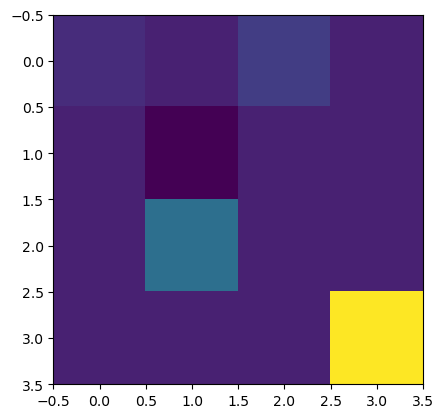

*********



In [87]:
initial_pos = 0;
env = GameEnvV1(4, 4, initial_pos)
state_space = env.rows * env.cols
agent = QAgent(initial_pos, state_space, len(list(env.action_space.keys())))
env.reset()
print(" DETERMINISTIC ENVIRONMENT ")
env.render()
print("*********\n")
agent = q_learning(agent, env, 500, 0.1, 0.1, 0.9)
# env.render()

In [88]:
agent.Q

array([[-0.58519851,  3.66978321, -0.64728794, -0.57568826, -0.72805907],
       [-0.38766465,  5.46510445, -0.3131209 , -0.29821684, -0.29701   ],
       [-0.58519851,  3.75741512, -0.56194395, -0.27710254, -0.57836018],
       [-0.199     ,  5.99095434,  0.33567532, -0.199     , -0.199     ],
       [-0.26263828,  6.43256742,  0.06027917, -0.35295786, -0.3940399 ],
       [ 0.18582812,  8.29849326,  0.15131897,  1.33464407,  0.23172537],
       [ 0.36845362,  6.17166301,  0.89857489, -0.19      , -0.1505505 ],
       [-0.20394125,  7.99819841,  0.4038544 ,  0.92002315,  1.10343233],
       [-0.28538199, -0.07605695,  1.51844489,  8.31895111,  0.96218986],
       [ 2.45586638,  2.79692221,  3.11078031,  6.2       ,  0.46930941],
       [ 1.43701466,  5.17161324,  2.60734601,  8.        ,  3.95241897],
       [ 4.07280047, 10.        ,  3.46326916,  4.86563627,  5.21057179],
       [ 5.87176734, -0.02991503, -0.3940399 , -0.30754722,  0.05367409],
       [ 7.63699425, -0.15148552, -0.1

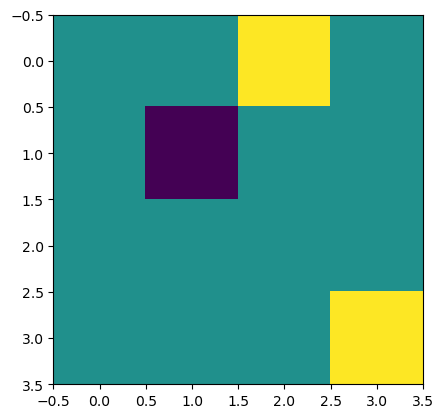

In [89]:
env.reset()
env.render()
agent.position = env.agent_position
max_moves = 20
while agent.position != (env.rows * env.cols) - 1 and max_moves > 0:
    action_idx = agent.choose_action(0)
    action = list(env.action_space.keys())[action_idx]
    pos, reward, terminal, info = env.step(action)
    agent.position = pos
    print(f'Action taken: {action}')
    time.sleep(1)
    env.render()
    max_moves -= 1


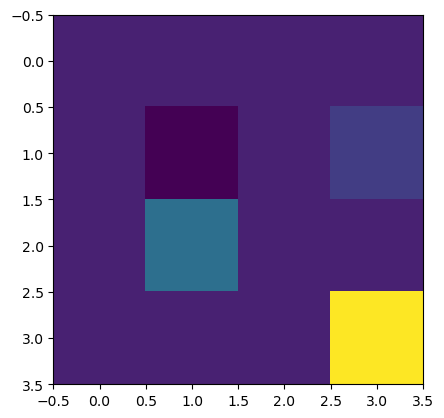

State: 1, action: Right, Reward: -1

State: 1, action: Up, Reward: 0

State: 2, action: Right, Reward: 1

State: 6, action: Down, Reward: -1

State: 10, action: Down, Reward: -1

State: 6, action: Up, Reward: -1

State: 2, action: Up, Reward: 1

State: 3, action: Right, Reward: -1

State: 7, action: Down, Reward: -1

State: 7, action: Right, Reward: 0



In [45]:
initial_pos = 0;
env = GameEnvV1(4, 4, initial_pos)
print(env.grid)
agent = RandomAgent(initial_pos, list(env.action_space.keys()))
env.reset()
print(" DETERMINISTIC ENVIRONMENT ")
env.render()
print("*********\n")
trainAgent(agent, env, 10, 0.1)
# env.render()

## Stochastic environment below
Not implemented properly yet. It's practically the same as above, just the step function is slightly different

In [93]:
class GameEnvV2(GameEnvV1):
    def step(self, action):
        if np.random.choice(4) == 0:
            action = 'Stall'

        return super().step(action)


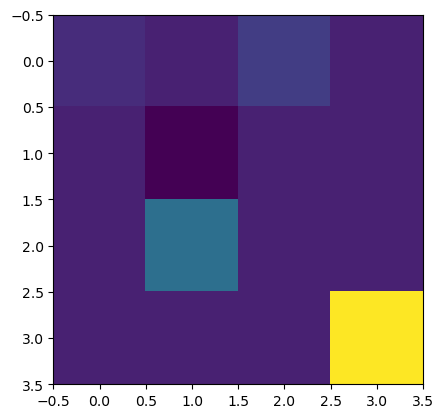

*********



In [94]:
initial_pos = 0;
env = GameEnvV2(4, 4, initial_pos)
state_space = env.rows * env.cols
agent = QAgent(initial_pos, state_space, len(list(env.action_space.keys())))
env.reset()
print(" STOCHASTIC ENVIRONMENT ")
env.render()
print("*********\n")
agent = q_learning(agent, env, 500, 0.1, 0.1, 0.9)
# env.render()

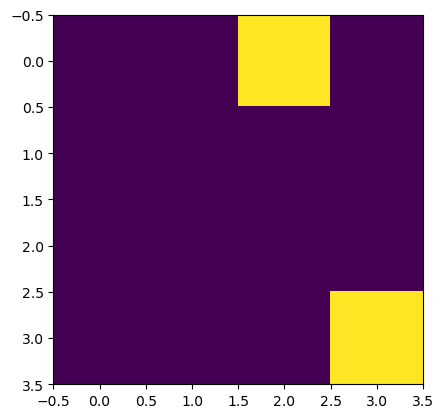

In [95]:
env.reset()
env.render()
agent.position = env.agent_position
max_moves = 20
while agent.position != (env.rows * env.cols) - 1 and max_moves > 0:
    action_idx = agent.choose_action(0)
    action = list(env.action_space.keys())[action_idx]
    pos, reward, terminal, info = env.step(action)
    agent.position = pos
    print(f'Action taken: {action}')
    time.sleep(1)
    env.render()
    max_moves -= 1
